<a href="https://colab.research.google.com/github/Aduwix/Toxic_comments_classification/blob/main/Classification_commentaires_toxiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sommaire
1. [Introduction](#introduction)
2. [Importation des packages](#ImportPackages)
3. [Importation des données](#ImportData)
4. [Etude du jeu de données](#StudyData)
5. [Préparation des données](#PrepareData)
6. [Passage du texte dans un format structuré](#StructureData)
7. [Entraînement du modèle baseline](#FirstModel)
8. [Deep Learning](#DL)
  1. [Première approche "*from scratch*"](#FromScratch)
  2. [Avec une couche d'embedding déjà entrainée](#GloVe)
  2. [LSTM bidirectionnel et Dropout](#Bidirectionnal)

# Introduction <a name="introduction"></a>

Dans ce notebook, nous allons tenter de classifier des commentaires dits toxiques.
Nous allons dans un premier temps étudier notre jeu de données pour comprendre ce que nous allons traiter.

Ensuite, avant de passer à la classification, il est nécessaire de préparer nos données. On s'occupe des contractions de mots, des abréviations et d'autres traitements avec notamment les stop words.

L'étape suivante correspond à l'élaboration de la matrice reprenant les TFIDF pour obtenir une représentation structurée de nos données. 


## Modèle de Machine Learning classique

Pour une première tentative de classification des commentaires, on part sur un algorithme de Machine Learning classique permettant de faire de la classification multi-label car un commentaire peut-être à la fois *severe_toxic* et *obscene*.

On obtient alors une précision d'environ 90%.

**Notre objectif est donc d'obtenir un modèle de deep learning ayant une précision du même ordre voire supérieure**

## Deep Learning

### From scratch

Dans cette première approche, on part d'un réseau de neurones à 3 couches:
  - Une couche d'embedding
  - Une couche GRU de taille 64
  - Une couche Dense de sortie

### Avec une couche d'embedding déjà entrainée: GloVe

Avec cette deuxième approche, on utilise une couche d'embedding déjà entrainée, GloVe.

# Importation des packages <a name="ImportPackages"></a>

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Réseaux de neurones
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importation des données <a name="ImportData"></a>

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [218]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [219]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


On ne prend pas la totalité du dataset pour l'entraînement pour ne pas passer trop de temps sur l'apprentissage.

In [220]:
len(data.index)
data = data.iloc[:30000, :]

# Etude du jeu de données <a name="StudyData"></a>

Une première étape consiste à enlever certains caractères spéciaux présents dans les commentaires.

In [221]:
data['comment_text'] = data['comment_text'].apply(lambda x : x.replace('\ufeff', ''))
data['comment_text'] = data['comment_text'].apply(lambda x : x.replace('\xa0', ''))
data['comment_text'] = data['comment_text'].apply(lambda x : x.replace('&#39;', ' '))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

On veut maintenant essayer de comprendre notre jeu de données avec différentes caractéristiques, on commence par la fréquence des commentaires selon leur classe type.

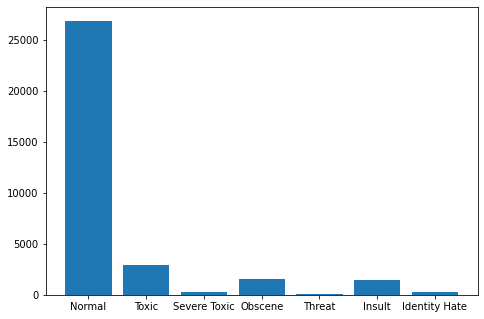

In [222]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
types = ["Normal", "Toxic", "Severe Toxic", "Obscene", "Threat", "Insult", "Identity Hate"]

#On définit nos différents labels
labels = data.columns[2:]

values = [len(data[(data['toxic'] == 0) & (data['severe_toxic'] == 0) & (data['obscene'] == 0) & (data['threat'] == 0) & (data['insult'] == 0) & (data['identity_hate'] == 0)])]
for column in labels:
  values.append(data[column].value_counts().to_numpy()[1])

ax.bar(types,values)
plt.show()

On remarque ici que le nombre de commentaires dits "normaux" est bien supérieur au nombre de commentaires toxiques de tous types. On remarque aussi que certaines classes sont plus présentes que d'autres: 'toxic', 'obscene' et 'insult' ont plus d'exemples que 'severe_toxic', 'threat' et 'identity hate'.

On peut aussi regarder la taille de nos commentaires

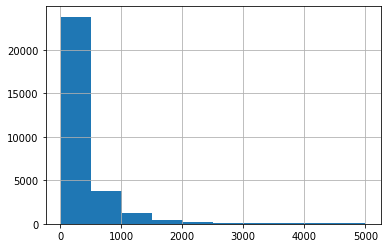

In [223]:
length = data['comment_text'].str.len()
length.hist()
plt.show()

On remarque que la longueur des commentaires (en caractères) est dans la majorité des cas inférieure à 500

In [224]:
print("Taille Moyenne d'un commentaire (nombre de caractères): {} ".format(np.mean(data['comment_text'].str.len())))
average_size = np.mean([len(comment.split()) for comment in data['comment_text']])
print("Taille Moyenne d'un commentaire (nombre de mots): {} ".format(average_size))

Taille Moyenne d'un commentaire (nombre de caractères): 393.14113333333336 
Taille Moyenne d'un commentaire (nombre de mots): 67.1352 


In [225]:
print("Taille Maximale d'un commentaire (nombre de caractères): {} ".format(np.max(data['comment_text'].str.len())))
max_size = np.max([len(comment.split()) for comment in data['comment_text']])
print("Taille Maximale d'un commentaire (nombre de mots): {} ".format(max_size))

Taille Maximale d'un commentaire (nombre de caractères): 5000 
Taille Maximale d'un commentaire (nombre de mots): 1403 


# Préparation des données <a name="PrepareData"></a>

L'objectif est maintenant de nettoyer le jeu de données. On va notamment essayer de remplacer les contractions et abreviations les plus courantes.

In [226]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


On définit plusieurs fonctions nous permettant de nettoyer les commentaires.

In [227]:
def clean(comment): 
            
    # Contractions
    comment = re.sub(r"he's", "he is", comment)
    comment = re.sub(r"there's", "there is", comment)
    comment = re.sub(r"We're", "We are", comment)
    comment = re.sub(r"That's", "That is", comment)
    comment = re.sub(r"won't", "will not", comment)
    comment = re.sub(r"they're", "they are", comment)
    comment = re.sub(r"Can't", "Cannot", comment)
    comment = re.sub(r"wasn't", "was not", comment)
    comment = re.sub(r"don\x89Ûªt", "do not", comment)
    comment = re.sub(r"aren't", "are not", comment)
    comment = re.sub(r"isn't", "is not", comment)
    comment = re.sub(r"What's", "What is", comment)
    comment = re.sub(r"haven't", "have not", comment)
    comment = re.sub(r"hasn't", "has not", comment)
    comment = re.sub(r"There's", "There is", comment)
    comment = re.sub(r"He's", "He is", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"You're", "You are", comment)
    comment = re.sub(r"I'M", "I am", comment)
    comment = re.sub(r"shouldn't", "should not", comment)
    comment = re.sub(r"wouldn't", "would not", comment)
    comment = re.sub(r"i'm", "I am", comment)
    comment = re.sub(r"I\x89Ûªm", "I am", comment)
    comment = re.sub(r"I'm", "I am", comment)
    comment = re.sub(r"Isn't", "is not", comment)
    comment = re.sub(r"Here's", "Here is", comment)
    comment = re.sub(r"you've", "you have", comment)
    comment = re.sub(r"you\x89Ûªve", "you have", comment)
    comment = re.sub(r"we're", "we are", comment)
    comment = re.sub(r"what's", "what is", comment)
    comment = re.sub(r"couldn't", "could not", comment)
    comment = re.sub(r"we've", "we have", comment)
    comment = re.sub(r"it\x89Ûªs", "it is", comment)
    comment = re.sub(r"doesn\x89Ûªt", "does not", comment)
    comment = re.sub(r"It\x89Ûªs", "It is", comment)
    comment = re.sub(r"Here\x89Ûªs", "Here is", comment)
    comment = re.sub(r"who's", "who is", comment)
    comment = re.sub(r"I\x89Ûªve", "I have", comment)
    comment = re.sub(r"y'all", "you all", comment)
    comment = re.sub(r"can\x89Ûªt", "cannot", comment)
    comment = re.sub(r"would've", "would have", comment)
    comment = re.sub(r"it'll", "it will", comment)
    comment = re.sub(r"we'll", "we will", comment)
    comment = re.sub(r"wouldn\x89Ûªt", "would not", comment)
    comment = re.sub(r"We've", "We have", comment)
    comment = re.sub(r"he'll", "he will", comment)
    comment = re.sub(r"Y'all", "You all", comment)
    comment = re.sub(r"Weren't", "Were not", comment)
    comment = re.sub(r"Didn't", "Did not", comment)
    comment = re.sub(r"they'll", "they will", comment)
    comment = re.sub(r"they'd", "they would", comment)
    comment = re.sub(r"DON'T", "DO NOT", comment)
    comment = re.sub(r"That\x89Ûªs", "That is", comment)
    comment = re.sub(r"they've", "they have", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"should've", "should have", comment)
    comment = re.sub(r"You\x89Ûªre", "You are", comment)
    comment = re.sub(r"where's", "where is", comment)
    comment = re.sub(r"Don\x89Ûªt", "Do not", comment)
    comment = re.sub(r"we'd", "we would", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"weren't", "were not", comment)
    comment = re.sub(r"They're", "They are", comment)
    comment = re.sub(r"Can\x89Ûªt", "Cannot", comment)
    comment = re.sub(r"you\x89Ûªll", "you will", comment)
    comment = re.sub(r"I\x89Ûªd", "I would", comment)
    comment = re.sub(r"let's", "let us", comment)
    comment = re.sub(r"it's", "it is", comment)
    comment = re.sub(r"can't", "cannot", comment)
    comment = re.sub(r"don't", "do not", comment)
    comment = re.sub(r"you're", "you are", comment)
    comment = re.sub(r"i've", "I have", comment)
    comment = re.sub(r"that's", "that is", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"doesn't", "does not", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"didn't", "did not", comment)
    comment = re.sub(r"ain't", "am not", comment)
    comment = re.sub(r"you'll", "you will", comment)
    comment = re.sub(r"I've", "I have", comment)
    comment = re.sub(r"Don't", "do not", comment)
    comment = re.sub(r"I'll", "I will", comment)
    comment = re.sub(r"I'd", "I would", comment)
    comment = re.sub(r"Let's", "Let us", comment)
    comment = re.sub(r"you'd", "You would", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"Ain't", "am not", comment)
    comment = re.sub(r"Haven't", "Have not", comment)
    comment = re.sub(r"Could've", "Could have", comment)
    comment = re.sub(r"youve", "you have", comment)  
    comment = re.sub(r"donå«t", "do not", comment)  
    
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"yrs", "years", comment)
    comment = re.sub(r"hrs", "hours", comment)
    comment = re.sub(r"2morow|2moro", "tomorrow", comment)
    comment = re.sub(r"2day", "today", comment)
    comment = re.sub(r"4got|4gotten", "forget", comment)
    comment = re.sub(r"b-day|bday", "b-day", comment)
    comment = re.sub(r"mother's", "mother", comment)
    comment = re.sub(r"mom's", "mom", comment)
    comment = re.sub(r"dad's", "dad", comment)
    comment = re.sub(r"hahah|hahaha|hahahaha", "haha", comment)
    comment = re.sub(r"lmao|lolz|rofl", "lol", comment)
    comment = re.sub(r"thanx|thnx", "thanks", comment)
    comment = re.sub(r"goood", "good", comment)
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"some1", "someone", comment)
    # Character entity references
    comment = re.sub(r"&gt;", ">", comment)
    comment = re.sub(r"&lt;", "<", comment)
    comment = re.sub(r"&amp;", "&", comment)
    # Typos, slang and informal abbreviations
    comment = re.sub(r"w/e", "whatever", comment)
    comment = re.sub(r"w/", "with", comment)
    comment = re.sub(r"<3", "love", comment)
    # Urls
    comment = re.sub(r"http\S+", "", comment)
    # Numbers
    comment = re.sub(r'[0-9]', '', comment)
    # Eliminating the mentions
    comment = re.sub("(@[A-Za-z0-9_]+)","", comment)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        comment = comment.replace(p, '')
        
    # ... and ..
    comment = comment.replace('...', ' ... ')
    if '...' not in comment:
        comment = comment.replace('..', ' ... ')
        
    # Tokenize
    comment_words = word_tokenize(comment)
    
    # Eliminating the word if its length is less than 3
    comment = [w for w in comment_words if len(w)>2]
    
    # remove stopwords
    comment = [w.lower() for w in comment if not w in stop_words]  
    
    
    # join back
    comment = ' '.join(comment)
        
        
    return comment

In [228]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(comment):
    t=[]
    words=comment.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

La fonction prepare_string permet d'appliquer les deux traitements définis précédemment pour netoyer les commentaires.

In [229]:
def prepare_string(comment):
  comment = clean(comment)
  comment = convert_abbrev_in_text(comment)
  return comment

In [230]:
%%time
data['comment_text'] = data['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
data['comment_text'].replace('', np.nan, inplace=True)
data.dropna(subset=['comment_text'], inplace=True)

CPU times: user 20.5 s, sys: 61.5 ms, total: 20.6 s
Wall time: 20.6 s


In [231]:
data.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why edits made username hardcore m...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more make real suggestions improvement wondere...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir hero any chance remember page,0,0,0,0,0,0
5,00025465d4725e87,congratulations well use tools well talk,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around work,1,1,1,0,1,0
7,00031b1e95af7921,your vandalism matt shirvington article revert...,0,0,0,0,0,0
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0


Nos commentaires sont maintenant nettoyés et prêts à être traités.

# Passage du texte dans un format structuré <a name="StructureData"></a>

In [232]:
corpus_size = int(100000)
#corpus_size = int(800)
#On va maintenant prendre un échantillon de notre dataset car TfidfVectorizer() a besoin d'énormément de ram pour ses calculs si on prend le dataset entier

sample_data = data.iloc[:corpus_size, :]

comments = sample_data['comment_text']

#On récupère maintenant les labels
y = sample_data.drop(columns=["comment_text", "id"]).values[:int(corpus_size)]


tfIdfVectorizer = TfidfVectorizer(max_features=5000)
X = tfIdfVectorizer.fit_transform(comments).toarray()

# Entraînement du modèle baseline <a name="FirstModel"></a>

Nous étions à la base partis sur un modèle de RandomForestClassifier comme dans les TP.
Nous avons donc constaté le manque de précision du modèle et fait une analyse afin d'améliorer la précision.
Mais nous nous sommes finalement rendu compte que ce modèle ne peut sortir qu'une seule classe à la fois. Autrement dit, un commentaire classé comme 'toxic' par le modèle ne sera jamais classé 'obscene' car le modèle ne pourra pas sortir deux labels en même temps.
Il faut donc utiliser un modèle permettant de faire de la multi-label classification.
On utilise ici OneVsRestClassifier.

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [234]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=15, random_state=1), n_jobs=-1)
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=15,
                                                     random_state=1),
                    n_jobs=-1)

On analyse maintenant les performances de notre modèle baseline

On regarde tout d'abord les performances sur les données d'entraînement

In [235]:
print(y_train[4], y_train[10])
print(model.predict([X_train[4], X_train[10]]))

training_predictions = model.predict(X_train)
print(classification_report(y_train,training_predictions, zero_division = 1))   

print(accuracy_score(y_train, training_predictions))

[1 0 1 0 0 0] [0 0 0 0 0 0]
[[1 0 1 0 0 0]
 [0 0 0 0 0 0]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2052
           1       1.00      0.87      0.93       223
           2       1.00      0.97      0.98      1098
           3       1.00      0.85      0.92        74
           4       1.00      0.97      0.98      1031
           5       0.99      0.91      0.95       182

   micro avg       1.00      0.96      0.98      4660
   macro avg       1.00      0.92      0.96      4660
weighted avg       1.00      0.96      0.98      4660
 samples avg       1.00      1.00      1.00      4660

0.9926649202190998


On voit ici que nous avons une précision de 99% sur le jeu de données d'entraînement.

Regardons maintenant les performances du modèle sur des données jamais rencontrées.

In [236]:
predictions = model.predict(X_test)
print(classification_report(y_test,predictions, zero_division = 1))   

accuracy0 = accuracy_score(y_test, predictions)
print("accuracy: {}".format(accuracy0))

              precision    recall  f1-score   support

           0       0.85      0.58      0.69       903
           1       0.23      0.03      0.06        93
           2       0.87      0.68      0.76       494
           3       0.00      0.00      0.00        25
           4       0.79      0.45      0.58       468
           5       0.90      0.11      0.20        82

   micro avg       0.84      0.52      0.64      2065
   macro avg       0.61      0.31      0.38      2065
weighted avg       0.81      0.52      0.62      2065
 samples avg       0.99      0.94      0.93      2065

accuracy: 0.9085352300511225


On remarque que nous avons une accuracy de 90%. Cela peut sembler correct mais on peut penser que, la dataset ayant en majorité des commentaires normaux, le modèle prédit qu'un commentaire est normal pour chaque type de commentaire.

In [237]:
def analysePredictions(predictions, y_test):
  num_col = len(predictions[0])
  num_rows = len(predictions)

  report = []

  for label in range(num_col):
    true_positive = false_positive = true_negative = false_negative = count = 0
    for i in range(num_rows):
      pred = predictions[i][label]
      answer = y_test[i][label]
      if pred == 1:
        if answer == 1:
          count += 1
          true_positive += 1
        else:
          false_positive += 1
      else:
        if answer == 0:
          true_negative += 1
        else:
          count += 1
          false_negative += 1
    report.append({
        'COUNT': count,
        'TP': true_positive,
        'FP': false_positive,
        'TN': true_negative,
        'FN': false_negative
    })
  return report

In [238]:
report = analysePredictions(predictions, y_test)

for i, label in enumerate(labels):
  print(
  """
  {}:
      Count: {}
      
        -True positive: {}
        -False positive: {}
        -True negative: {}
        -False negative: {} 

{}
  """.format(label, report[i]['COUNT'], report[i]['TP'], report[i]['FP'], report[i]['TN'], report[i]['FN'], confusion_matrix(y_test[:, i], predictions[:,i]))#On a aussi la possibilité d'utiliser confusion_matrix pour déterminer ces valeurs
  )


  toxic:
      Count: 903
      
        -True positive: 522
        -False positive: 89
        -True negative: 8006
        -False negative: 381 

[[8006   89]
 [ 381  522]]
  

  severe_toxic:
      Count: 93
      
        -True positive: 3
        -False positive: 10
        -True negative: 8895
        -False negative: 90 

[[8895   10]
 [  90    3]]
  

  obscene:
      Count: 494
      
        -True positive: 335
        -False positive: 52
        -True negative: 8452
        -False negative: 159 

[[8452   52]
 [ 159  335]]
  

  threat:
      Count: 25
      
        -True positive: 0
        -False positive: 1
        -True negative: 8972
        -False negative: 25 

[[8972    1]
 [  25    0]]
  

  insult:
      Count: 468
      
        -True positive: 212
        -False positive: 55
        -True negative: 8475
        -False negative: 256 

[[8475   55]
 [ 256  212]]
  

  identity_hate:
      Count: 82
      
        -True positive: 9
        -False positive: 1
    

En analysant ces indicateurs, on se rend alors compte qu'en réalité, le modèle n'arrive pas à bien classer les commentaires toxiques en général, ceux qu'il n'a jamais rencontré.
On voit notamment que nous avons beaucoup de faux négatifs.
La méthode utilisant le tfidf ne semble pas être réellement performante pour de nouvelles données.
En effet, le modèle ne semble pas être capable de généraliser.

# Deep Learning <a name="DL"></a>

## Première approche "*from scratch*" <a name="FromScratch"></a>

Nous allons maintenant tenter d'améliorer les performances de notre modèle en passant par un réseau de neurones.

Nous avons pour objectif d'obtenir une précision d'au moins 90%.

Hyperparamètres

In [239]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 70        # Maximum size of a comment
truncating='post'      # Truncates the comment if it is longer than max_length
padding='post'    # Adds padding to the end of the comment if it is shorter than max_length
oov_token = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(data)
test_portion=.25

In [240]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data = data.iloc[:50000, :]

In [241]:
%%time
data['comment_text'] = data['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
data['comment_text'].replace('', np.nan, inplace=True)
data.dropna(subset=['comment_text'], inplace=True)

CPU times: user 34.6 s, sys: 129 ms, total: 34.7 s
Wall time: 34.7 s


In [242]:
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(data["comment_text"])

On a maintenant un vecteur de mapping avec nos mots de notre vocabulaire

In [243]:
word_index = tokenizer.word_index

In [244]:
vocab_size = len(tokenizer.word_index)
print(vocab_size)

103948


In [245]:
sequences = tokenizer.texts_to_sequences(data["comment_text"])
x = pad_sequences(sequences, truncating=truncating, padding=padding, maxlen=max_length)
#x = np.asarray(x).astype(np.float32)

In [246]:
sequences[0]

[555,
 127,
 49,
 50,
 508,
 4795,
 10274,
 671,
 214,
 218,
 8921,
 5611,
 2351,
 2701,
 40,
 941,
 12404,
 2433,
 23,
 9,
 149,
 332,
 8,
 4,
 59,
 3498]

### Initialisation du modèle

Nous allons dans un premier temps créer un modèle à partir de rien.

In [247]:
tf.keras.utils.set_random_seed(123)

model = tf.keras.Sequential(
    [
     tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_length),
     tf.keras.layers.GRU(64),
     tf.keras.layers.Dense(len(labels), activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005),metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 70, 100)           10394900  
                                                                 
 gru_10 (GRU)                (None, 64)                31872     
                                                                 
 dense_12 (Dense)            (None, 6)                 390       
                                                                 
Total params: 10,427,162
Trainable params: 10,427,162
Non-trainable params: 0
_________________________________________________________________


On a notre modèle. Il faut maintenant l'entraîner.

In [248]:
num_epochs = 30

On définit nos ensembles d'entraînement et de test.

In [249]:
y = data.drop(columns=["comment_text", "id"]).values[:len(x)]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_portion)

On entraîne le modèle.

In [250]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=256, epochs = num_epochs, validation_data = (np.array(X_test), np.array(y_test)) ,verbose=1)
print("Training Complete")

Epoch 1/30
147/147 [==============================] - 7s 30ms/step - loss: 0.1580 - accuracy: 0.9259 - val_loss: 0.1170 - val_accuracy: 0.9868
Epoch 2/30
147/147 [==============================] - 4s 26ms/step - loss: 0.0666 - accuracy: 0.9782 - val_loss: 0.0565 - val_accuracy: 0.9951
Epoch 3/30
147/147 [==============================] - 4s 26ms/step - loss: 0.0410 - accuracy: 0.9459 - val_loss: 0.0556 - val_accuracy: 0.9690
Epoch 4/30
147/147 [==============================] - 4s 25ms/step - loss: 0.0304 - accuracy: 0.9420 - val_loss: 0.0609 - val_accuracy: 0.9359
Epoch 5/30
147/147 [==============================] - 4s 26ms/step - loss: 0.0243 - accuracy: 0.9084 - val_loss: 0.0663 - val_accuracy: 0.9085
Epoch 6/30
147/147 [==============================] - 4s 26ms/step - loss: 0.0194 - accuracy: 0.8391 - val_loss: 0.0736 - val_accuracy: 0.8580
Epoch 7/30
147/147 [==============================] - 4s 26ms/step - loss: 0.0149 - accuracy: 0.7428 - val_loss: 0.0772 - val_accuracy: 0.6383

In [251]:
predictions = model.predict(X_test)
predictions = (predictions >= .5)
accuracy1 = accuracy_score(y_test, predictions)
print("accuracy: {}".format(accuracy1))

report = analysePredictions(predictions, y_test)

for i, label in enumerate(labels):
  print(
  """
{}:
    Count: {}
      
      -True positive: {}
      -False positive: {}
      -True negative: {}
      -False negative: {} 

{}
  """.format(label, report[i]['COUNT'], report[i]['TP'], report[i]['FP'], report[i]['TN'], report[i]['FN'], confusion_matrix(y_test[:, i], predictions[:,i]))#On a aussi la possibilité d'utiliser confusion_matrix pour déterminer ces valeurs
  )

accuracy: 0.8947747459390254

toxic:
    Count: 1234
      
      -True positive: 802
      -False positive: 326
      -True negative: 10937
      -False negative: 432 

[[10937   326]
 [  432   802]]
  

severe_toxic:
    Count: 130
      
      -True positive: 44
      -False positive: 50
      -True negative: 12317
      -False negative: 86 

[[12317    50]
 [   86    44]]
  

obscene:
    Count: 637
      
      -True positive: 459
      -False positive: 145
      -True negative: 11715
      -False negative: 178 

[[11715   145]
 [  178   459]]
  

threat:
    Count: 44
      
      -True positive: 10
      -False positive: 20
      -True negative: 12433
      -False negative: 34 

[[12433    20]
 [   34    10]]
  

insult:
    Count: 617
      
      -True positive: 328
      -False positive: 137
      -True negative: 11743
      -False negative: 289 

[[11743   137]
 [  289   328]]
  

identity_hate:
    Count: 108
      
      -True positive: 39
      -False positive: 34
      -

On remarque ici que notre modèle basé sur un réseau de neurones avec une couche d'embeddings, une couche LSTM et une simple couche dense de sortie nous permet d'avoir une précision de l'ordre de 90%, comme un modèle de machine learning classique.
On voit aussi que nous avons encore un grand nombre de faux négatifs sur les classes peu représentées.

Voici ci-dessous une fonction de permettant de classifier un ou plusieurs commentaires

In [252]:
def analyseComments(comments):
  if isinstance(comments, str): #La fonction peut prendre en paramètre une simple string 
    comments = [comments]
  sequences = tokenizer.texts_to_sequences(comments)
  x = pad_sequences(sequences, truncating=truncating, padding=padding, maxlen=max_length)

  predictions = model.predict(x)
  predictions = (predictions >= .5)

  result = []

  for i, pred in enumerate(predictions):
    tmp = []
    for j, label in enumerate(labels):
      if pred[j]:
        tmp.append(label)
    
    if not tmp: #Si aucun label n'est choisi, alors le commentaire est normal
      tmp.append('normal')

    result.append(tmp)
  
  return result

Un exemple d'utilisation de cette fonction

In [253]:
comments = ["cocksucker before you piss around work", "bad video bitch", "cool video dude i love you"]
result = analyseComments(comments)

for i, comment in enumerate(comments):
  print("'{}':".format(comment))
  for res in result[i]:
    print("\t-{}".format(res))
  print("\n")

'cocksucker before you piss around work':
	-toxic
	-severe_toxic
	-obscene
	-insult


'bad video bitch':
	-toxic
	-obscene


'cool video dude i love you':
	-normal




On peut aussi traiter un seul commentaire.

In [254]:
analyseComments("cocksucker before you piss around work")[0]

['toxic', 'severe_toxic', 'obscene', 'insult']

## Avec une couche d'embedding déjà entrainée <a name="GloVe"></a>

Nous allons maintenant essayer d'améliorer notre modèle précédent à l'aide d'une couche d'embedding déjà entraînée

In [255]:
embeddings_index = {};

with open('/content/drive/MyDrive/RNN_sentiment_dataset/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

Initialisation du modèle

In [256]:
tf.keras.utils.set_random_seed(123)
model_emb = tf.keras.Sequential(
    [
     tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
     tf.keras.layers.GRU(64),
     tf.keras.layers.Dense(len(labels), activation='sigmoid')
    ]
)

Compilation du modèle

In [257]:
model_emb.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005),metrics=['accuracy'])

In [258]:
model_emb.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 70, 100)           10394900  
                                                                 
 gru_11 (GRU)                (None, 64)                31872     
                                                                 
 dense_13 (Dense)            (None, 6)                 390       
                                                                 
Total params: 10,427,162
Trainable params: 32,262
Non-trainable params: 10,394,900
_________________________________________________________________


Entraînement du modèle

In [259]:
history = model_emb.fit(np.array(X_train), np.array(y_train), batch_size=256, epochs = num_epochs, validation_data = (np.array(X_test), np.array(y_test)) ,verbose=1)
  
print("Training Complete")

Epoch 1/30
147/147 [==============================] - 6s 28ms/step - loss: 0.1203 - accuracy: 0.8640 - val_loss: 0.0612 - val_accuracy: 0.9952
Epoch 2/30
147/147 [==============================] - 3s 22ms/step - loss: 0.0581 - accuracy: 0.9843 - val_loss: 0.0552 - val_accuracy: 0.9925
Epoch 3/30
147/147 [==============================] - 3s 22ms/step - loss: 0.0525 - accuracy: 0.9599 - val_loss: 0.0533 - val_accuracy: 0.9850
Epoch 4/30
147/147 [==============================] - 3s 22ms/step - loss: 0.0483 - accuracy: 0.9702 - val_loss: 0.0526 - val_accuracy: 0.9742
Epoch 5/30
147/147 [==============================] - 3s 22ms/step - loss: 0.0451 - accuracy: 0.9671 - val_loss: 0.0525 - val_accuracy: 0.8851
Epoch 6/30
147/147 [==============================] - 4s 24ms/step - loss: 0.0417 - accuracy: 0.9530 - val_loss: 0.0554 - val_accuracy: 0.9731
Epoch 7/30
147/147 [==============================] - 3s 22ms/step - loss: 0.0386 - accuracy: 0.9614 - val_loss: 0.0544 - val_accuracy: 0.9634

In [260]:
predictions = model_emb.predict(X_test)
predictions = (predictions >= .5)
accuracy2 = accuracy_score(y_test, predictions)
print("accuracy: {}".format(accuracy2))

report = analysePredictions(predictions, y_test)

for i, label in enumerate(labels):
  print(
  """
{}:
    Count: {}
      
      -True positive: {}
      -False positive: {}
      -True negative: {}
      -False negative: {} 

{}
  """.format(label, report[i]['COUNT'], report[i]['TP'], report[i]['FP'], report[i]['TN'], report[i]['FN'], confusion_matrix(y_test[:, i], predictions[:,i]))#On a aussi la possibilité d'utiliser confusion_matrix pour déterminer ces valeurs
  )

accuracy: 0.9012563015123629

toxic:
    Count: 1234
      
      -True positive: 872
      -False positive: 287
      -True negative: 10976
      -False negative: 362 

[[10976   287]
 [  362   872]]
  

severe_toxic:
    Count: 130
      
      -True positive: 32
      -False positive: 33
      -True negative: 12334
      -False negative: 98 

[[12334    33]
 [   98    32]]
  

obscene:
    Count: 637
      
      -True positive: 437
      -False positive: 120
      -True negative: 11740
      -False negative: 200 

[[11740   120]
 [  200   437]]
  

threat:
    Count: 44
      
      -True positive: 5
      -False positive: 13
      -True negative: 12440
      -False negative: 39 

[[12440    13]
 [   39     5]]
  

insult:
    Count: 617
      
      -True positive: 312
      -False positive: 124
      -True negative: 11756
      -False negative: 305 

[[11756   124]
 [  305   312]]
  

identity_hate:
    Count: 108
      
      -True positive: 38
      -False positive: 34
      -T

In [261]:
print("Accuracy du modèle baseline: {}".format(accuracy0))
print("Accuracy du modèle DL from scratch: {}".format(accuracy1))
print("Accuracy du modèle DL avec couche d'embedding entrainée: {}".format(accuracy2))

Accuracy du modèle baseline: 0.9085352300511225
Accuracy du modèle DL from scratch: 0.8947747459390254
Accuracy du modèle DL avec couche d'embedding entrainée: 0.9012563015123629


On remarque que l'ajout d'une couche d'embedding déjà entrainée de permet pas d'obtenir une meilleure précision. 
On peut donc garder notre premier modèle de Deep Learning sans problème.

In [266]:
def analyseComments_emb(comments):
  if isinstance(comments, str): #La fonction peut prendre en paramètre une simple string 
    comments = [comments]
  sequences = tokenizer.texts_to_sequences(comments)
  x = pad_sequences(sequences, truncating=truncating, padding=padding, maxlen=max_length)

  predictions = model_emb.predict(x)
  predictions = (predictions >= .5)

  result = []

  for i, pred in enumerate(predictions):
    tmp = []
    for j, label in enumerate(labels):
      if pred[j]:
        tmp.append(label)
    
    if not tmp: #Si aucun label n'est choisi, alors le commentaire est normal
      tmp.append('normal')

    result.append(tmp)
  
  return result

In [268]:
comments = ["the accuracy of our model is only 90%", "this model is shit", "This model is really great!"]
result = analyseComments(comments)

for i, comment in enumerate(comments):
  print("'{}':".format(comment))
  for res in result[i]:
    print("\t-{}".format(res))
  print("\n")

print("Model with embedding trained")
#Avec le deuxième modèle avec une couche d'embedding entrainée
result = analyseComments_emb(comments)

for i, comment in enumerate(comments):
  print("'{}':".format(comment))
  for res in result[i]:
    print("\t-{}".format(res))
  print("\n")

'the accuracy of our model is only 90%':
	-normal


'this model is shit':
	-toxic
	-obscene
	-insult


'This model is really great!':
	-normal


Model with embedding trained
'the accuracy of our model is only 90%':
	-normal


'this model is shit':
	-toxic
	-obscene


'This model is really great!':
	-normal




Ci-dessous une tentative d'amélioration du modèle.

## LSTM Bidirectionnel et dropout <a name="Bidirectionnal">

On essaye ici d'améliorer le modèle en le rendant moins susceptible à l'overfit grâce au dropout.
On utilise aussi une couche LSTM bidirectionnelle pour essayer d'avoir une meilleure compréhension des commentaires en ayant aussi des informations futures.

In [278]:
model_drop = tf.keras.Sequential(
    [
     tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
     tf.keras.layers.Dropout(.4),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
     tf.keras.layers.Dense(len(labels), activation='sigmoid')
    ]
)

model_drop.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [279]:
model_drop.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 70, 100)           10394900  
                                                                 
 dropout_6 (Dropout)         (None, 70, 100)           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 10,630,938
Trainable params: 236,038
Non-trainable params: 10,394,900
_________________________________________________________________


In [280]:
history = model_drop.fit(np.array(X_train), np.array(y_train), batch_size=256, epochs = 60, validation_data = (np.array(X_test), np.array(y_test)) ,verbose=1)
  
print("Training Complete")

Epoch 1/60
147/147 [==============================] - 13s 67ms/step - loss: 0.1277 - accuracy: 0.9413 - val_loss: 0.0771 - val_accuracy: 0.9946
Epoch 2/60
147/147 [==============================] - 7s 51ms/step - loss: 0.0755 - accuracy: 0.9909 - val_loss: 0.0672 - val_accuracy: 0.9952
Epoch 3/60
147/147 [==============================] - 7s 49ms/step - loss: 0.0690 - accuracy: 0.9844 - val_loss: 0.0631 - val_accuracy: 0.9946
Epoch 4/60
147/147 [==============================] - 7s 48ms/step - loss: 0.0651 - accuracy: 0.9882 - val_loss: 0.0606 - val_accuracy: 0.9880
Epoch 5/60
147/147 [==============================] - 7s 48ms/step - loss: 0.0629 - accuracy: 0.9900 - val_loss: 0.0579 - val_accuracy: 0.9886
Epoch 6/60
147/147 [==============================] - 7s 48ms/step - loss: 0.0616 - accuracy: 0.9837 - val_loss: 0.0570 - val_accuracy: 0.9948
Epoch 7/60
147/147 [==============================] - 7s 48ms/step - loss: 0.0593 - accuracy: 0.9875 - val_loss: 0.0585 - val_accuracy: 0.992

In [281]:
predictions = model_drop.predict(X_test)
predictions = (predictions >= .5)
accuracy3 = accuracy_score(y_test, predictions)
print("accuracy: {}".format(accuracy3))

report = analysePredictions(predictions, y_test)

for i, label in enumerate(labels):
  print(
  """
{}:
    Count: {}
      
      -True positive: {}
      -False positive: {}
      -True negative: {}
      -False negative: {} 

{}
  """.format(label, report[i]['COUNT'], report[i]['TP'], report[i]['FP'], report[i]['TN'], report[i]['FN'], confusion_matrix(y_test[:, i], predictions[:,i]))#On a aussi la possibilité d'utiliser confusion_matrix pour déterminer ces valeurs
  )

accuracy: 0.9111786828838921

toxic:
    Count: 1234
      
      -True positive: 760
      -False positive: 111
      -True negative: 11152
      -False negative: 474 

[[11152   111]
 [  474   760]]
  

severe_toxic:
    Count: 130
      
      -True positive: 27
      -False positive: 23
      -True negative: 12344
      -False negative: 103 

[[12344    23]
 [  103    27]]
  

obscene:
    Count: 637
      
      -True positive: 435
      -False positive: 86
      -True negative: 11774
      -False negative: 202 

[[11774    86]
 [  202   435]]
  

threat:
    Count: 44
      
      -True positive: 9
      -False positive: 11
      -True negative: 12442
      -False negative: 35 

[[12442    11]
 [   35     9]]
  

insult:
    Count: 617
      
      -True positive: 317
      -False positive: 106
      -True negative: 11774
      -False negative: 300 

[[11774   106]
 [  300   317]]
  

identity_hate:
    Count: 108
      
      -True positive: 26
      -False positive: 12
      -T

On a finalement un modèle un peu plus précis avec environ 91% de précision.

In [284]:
def analyseComments_drop(comments):
  if isinstance(comments, str): #La fonction peut prendre en paramètre une simple string 
    comments = [comments]
  sequences = tokenizer.texts_to_sequences(comments)
  x = pad_sequences(sequences, truncating=truncating, padding=padding, maxlen=max_length)

  predictions = model_drop.predict(x)
  predictions = (predictions >= .5)

  result = []

  for i, pred in enumerate(predictions):
    tmp = []
    for j, label in enumerate(labels):
      if pred[j]:
        tmp.append(label)
    
    if not tmp: #Si aucun label n'est choisi, alors le commentaire est normal
      tmp.append('normal')

    result.append(tmp)
  
  return result

In [285]:
comments = ["Bidirectionnal is shit", "Not at all, bidirectionnal and dropout seems great"]
result = analyseComments_drop(comments)
for i, comment in enumerate(comments):
  print("'{}':".format(comment))
  for res in result[i]:
    print("\t-{}".format(res))
  print("\n")

'Bidirectionnal is shit':
	-toxic
	-obscene


'Not at all, bidirectionnal and dropout seems great':
	-normal


